# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress
from gpuocean.SWEsimulators import CDKLM16, CDKLM16pair

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx0

In [5]:
%cuda_context_handler gpu_ctx1

In [6]:
%cuda_context_handler gpu_ctx2

In [7]:
%cuda_context_handler gpu_ctx3

In [8]:
%cuda_context_handler gpu_ctx4

## Setting-up case with different resolutions

IC are the bump from the Rossby adjustment case

In [9]:
def initBump(data_args, dataShape, d_shift=1e6,D=0.5*1e6):

    eta0  = np.zeros(dataShape, dtype=np.float32, order='C')
    hu0   = np.zeros(dataShape, dtype=np.float32, order='C')
    hv0   = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = data_args["dx"]*(data_args["nx"]+4)*0.5
    y_center = data_args["dy"]*(data_args["ny"]+4)*0.5

    scale = 1e9
    for j in range(data_args["ny"] + 4):
        for i in range(data_args["nx"] + 4):
            x = data_args["dx"]*i - x_center
            y = data_args["dy"]*j - y_center

            d = np.sqrt(x**2 + y**2)
            
            eta0[j, i] += 0.1*(1.0+np.tanh(-(d-d_shift)/D))

    return eta0, hu0, hv0

In [10]:
def initLevel(l):
    data_args = {}
    data_args["nx"] = 2**l
    data_args["ny"] = 2**l 
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)

    data_args["dx"] = 2**(19-l)*100
    data_args["dy"] = 2**(19-l)*100

    data_args["dt"] = 0.0
    data_args["g"] = 9.81
    data_args["f"] = 1.2e-4
    data_args["r"] = 0.0
    # data_args["boundary_conditions"] = Common.BoundaryConditions(1,1,1,1)

    data_args["eta0"], data_args["hu0"], data_args["hv0"] = initBump(data_args, dataShape)
    
    H0 = 1000.0
    data_args["H"] = np.ma.array(np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H0, mask=False)

    return data_args

In [15]:
ls = [7, 8, 9, 10]

Text(0.5, 0.75, 'Initial Conditions')

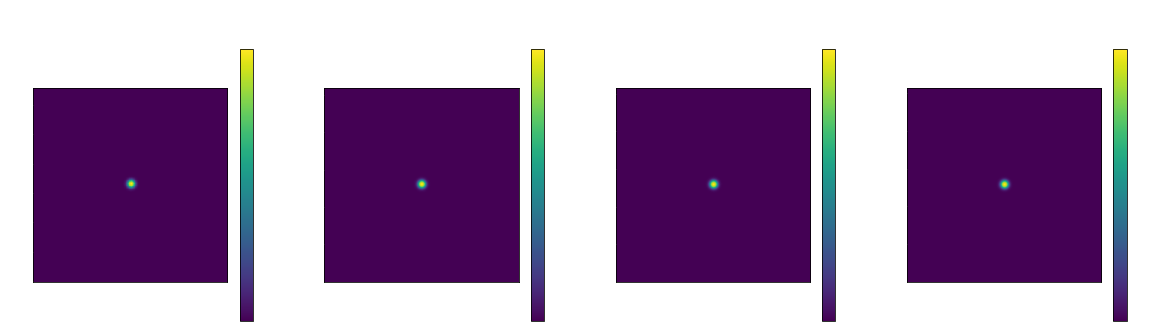

In [34]:
fig, axs = plt.subplots(1,len(ls), figsize=(20,10))

for l_idx, l in enumerate(ls):
    data_args = initLevel(l)
    im = axs[l_idx].imshow(data_args["eta0"])
    plt.colorbar(im, ax=axs[l_idx], shrink=0.5)

plt.suptitle("Initial Conditions", y=0.75)

### (Deterministic) Simulation on different Resolutions

In [17]:
for l_idx, l  in enumerate(ls):
    data_args = initLevel(l)
    exec("sim"+str(l_idx)+" = CDKLM16.CDKLM16(gpu_ctx"+str(l_idx)+", **data_args)")
    exec("sim"+str(l_idx)+".step(250000)")

In [ ]:
sim1 = runLevel(gpu_ctx1, 8)

In [ ]:
sim2 = runLevel(gpu_ctx2, 9)

In [ ]:
sim3 = runLevel(gpu_ctx3, 10)

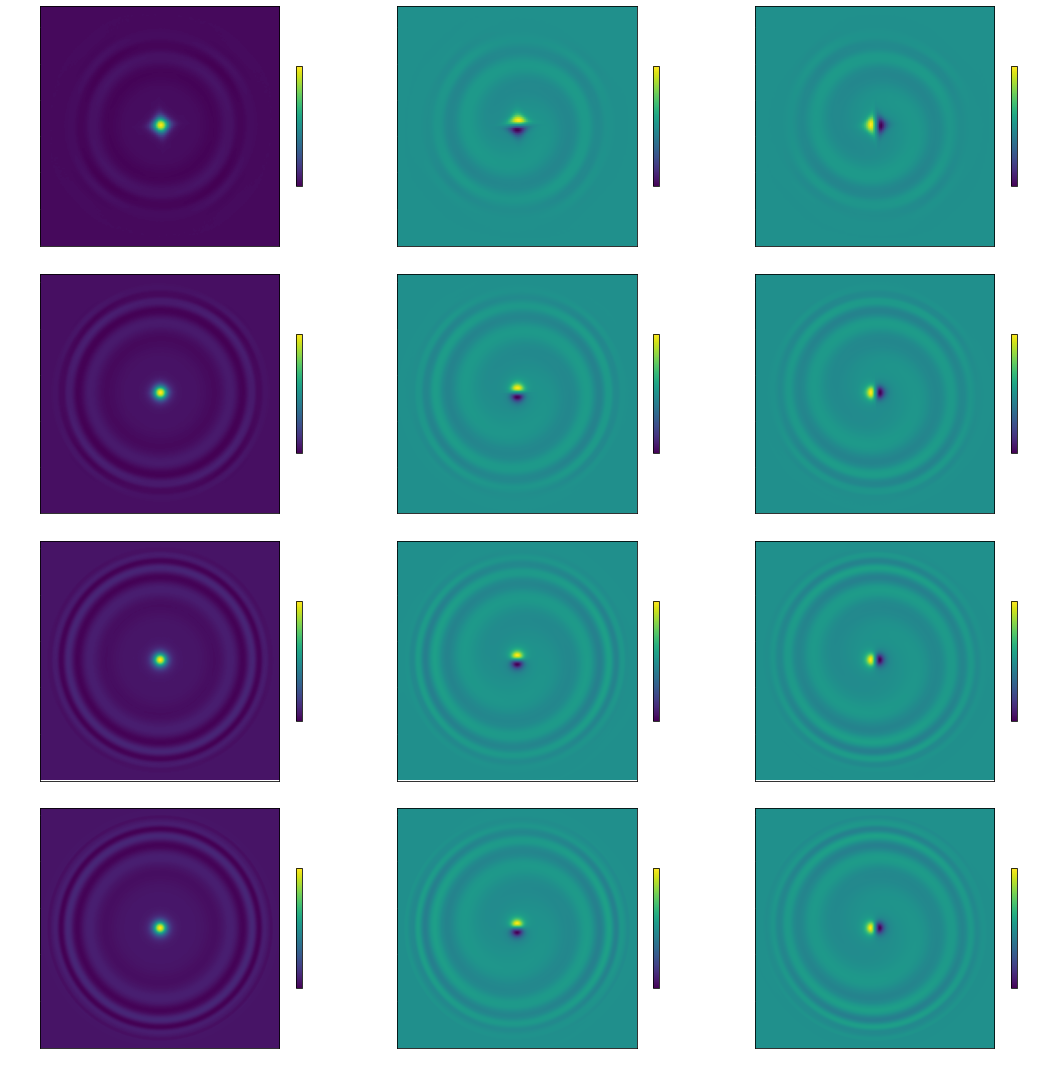

In [18]:
fig, axs = plt.subplots(len(ls),3, figsize=(15,15))

for j in range(len(ls)):
    for i in range(3):
        im = axs[j,i].imshow(eval("sim"+str(j)).download()[i])
        plt.colorbar(im, ax=axs[j,i], shrink=0.5)
plt.tight_layout()

### Perturbation from wind direction

Wind field is faded out towards the walls. 
*So far only one random parameter but Matern field of wind intended.*

In [19]:
def wind_bump(data_args, sig = 1e+14):
    dataShape = (data_args["ny"] + 4, data_args["nx"] + 4)
    w = np.zeros(dataShape, dtype=np.float32, order='C')

    x_center = data_args["dx"]*(data_args["nx"]+4)*0.5
    y_center = data_args["dy"]*(data_args["ny"]+4)*0.5

    for j in range(data_args["ny"] + 4):
        for i in range(data_args["nx"] + 4):
            x = data_args["dx"]*i - x_center
            y = data_args["dy"]*j - y_center

            d = x**2 + y**2
            
            w[j, i] = np.exp(-1/2*d/sig)    
    
    return w

Text(0.5, 1.0, 'Fine')

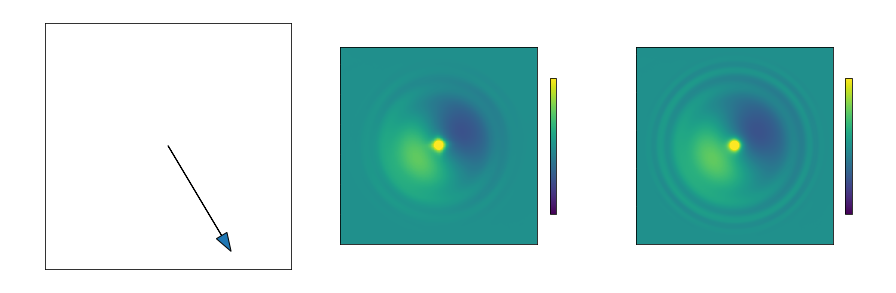

In [30]:
data_args = initLevel(7)
wind_degree = np.deg2rad(np.random.uniform(0,360))
wind_speed  = 10
wind_weight = wind_bump(data_args)
wind = WindStress.WindStress(t=[0], wind_u=[np.array(wind_weight*[[wind_speed*np.sin(wind_degree)]], dtype=np.float32)], wind_v=[np.array(wind_weight*[[wind_speed*np.cos(wind_degree)]], dtype=np.float32)])
sim = CDKLM16.CDKLM16(gpu_ctx1, **data_args, wind=wind)
sim.step(250000)

data_args = initLevel(8)
wind_weight = wind_bump(data_args)
wind = WindStress.WindStress(t=[0], wind_u=[np.array(wind_weight*[[wind_speed*np.sin(wind_degree)]], dtype=np.float32)], wind_v=[np.array(wind_weight*[[wind_speed*np.cos(wind_degree)]], dtype=np.float32)])
sim2 = CDKLM16.CDKLM16(gpu_ctx2, **data_args, wind=wind)
sim2.step(250000)

fig, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].arrow(0,0,np.sin(wind_degree), np.cos(wind_degree), head_width=0.1, length_includes_head=True)
axs[0].set_xlim((-1,1))
axs[0].set_ylim((-1,1))
axs[0].set_aspect("equal")
axs[0].set_title("Wind direction")
im = axs[1].imshow(sim.download()[0], vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[1], shrink=0.25)
axs[1].set_title("Coarse")
im = axs[2].imshow(sim2.download()[0], vmin=-0.05, vmax=0.05)
plt.colorbar(im, ax=axs[2], shrink=0.25)
axs[2].set_title("Fine")

## Variance Level Plot

In [36]:
N_var = 100

vars = np.zeros((len(ls), 3))
diff_vars = np.zeros((len(ls), 3))

for l_idx, l in enumerate(ls):
    print("Level ", l_idx)
    data_args0 = initLevel(l)
    wind_weight0 = wind_bump(data_args0)

    data_args1 = initLevel(l-1)
    wind_weight1 = wind_bump(data_args1)

    # Storage allocation
    est_mean = np.zeros((3,data_args0["ny"],data_args0["nx"]))

    samples0 = np.zeros((3,data_args0["ny"],data_args0["nx"],N_var)) 
    samples1 = np.zeros((3,data_args1["ny"],data_args1["nx"],N_var)) 

    for i in range(N_var):
        print("Sample ", i)

        # Perturbation sampling
        wind_degree = np.deg2rad(np.random.uniform(0,360))
        wind_speed  = 10
        data_args0["wind"] = WindStress.WindStress(t=[0], wind_u=[np.array(wind_weight0*[[wind_speed*np.sin(wind_degree)]], dtype=np.float32)], wind_v=[np.array(wind_weight0*[[wind_speed*np.cos(wind_degree)]], dtype=np.float32)])

        ## Fine sim
        sim0 = CDKLM16.CDKLM16(gpu_ctx, **data_args0)
        sim0.step(250000)

        eta, hu, hv = sim0.download(interior_domain_only=True)
        samples0[0,:,:,i] = eta
        samples0[1,:,:,i] = hu
        samples0[2,:,:,i] = hv

        sim0.cleanUp()

        ## Coarse partner sim

        data_args1["wind"] = WindStress.WindStress(t=[0], wind_u=[np.array(wind_weight1*[[wind_speed*np.sin(wind_degree)]], dtype=np.float32)], wind_v=[np.array(wind_weight1*[[wind_speed*np.cos(wind_degree)]], dtype=np.float32)])

        sim1 = CDKLM16.CDKLM16(gpu_ctx, **data_args1)
        sim1.step(250000)

        eta, hu, hv = sim1.download(interior_domain_only=True)
        samples1[0,:,:,i] = eta
        samples1[1,:,:,i] = hu
        samples1[2,:,:,i] = hv

        sim1.cleanUp()

    vars[l_idx,0] = np.sqrt(np.average(np.var(samples1[0], axis=-1)**2))
    vars[l_idx,1] = np.sqrt(np.average(np.var(samples1[1], axis=-1)**2))
    vars[l_idx,2] = np.sqrt(np.average(np.var(samples1[2], axis=-1)**2))

    diff_vars[l_idx,0] = np.sqrt(np.average(np.var((samples0 - samples1.repeat(2,1).repeat(2,2))[0], axis=-1)**2))
    diff_vars[l_idx,1] = np.sqrt(np.average(np.var((samples0 - samples1.repeat(2,1).repeat(2,2))[1], axis=-1)**2))
    diff_vars[l_idx,2] = np.sqrt(np.average(np.var((samples0 - samples1.repeat(2,1).repeat(2,2))[2], axis=-1)**2))

Level  0
Sample  0
Sample  1
Sample  2
Sample  3
Sample  4
Sample  5
Sample  6
Sample  7
Sample  8
Sample  9
Sample  10
Sample  11
Sample  12
Sample  13
Sample  14
Sample  15
Sample  16
Sample  17
Sample  18
Sample  19
Sample  20
Sample  21
Sample  22
Sample  23
Sample  24
Sample  25
Sample  26
Sample  27
Sample  28
Sample  29
Sample  30
Sample  31
Sample  32
Sample  33
Sample  34
Sample  35
Sample  36
Sample  37
Sample  38
Sample  39
Sample  40
Sample  41
Sample  42
Sample  43
Sample  44
Sample  45
Sample  46
Sample  47
Sample  48
Sample  49
Sample  50
Sample  51
Sample  52
Sample  53
Sample  54
Sample  55
Sample  56
Sample  57
Sample  58
Sample  59
Sample  60
Sample  61
Sample  62
Sample  63
Sample  64
Sample  65
Sample  66
Sample  67
Sample  68
Sample  69
Sample  70
Sample  71
Sample  72
Sample  73
Sample  74
Sample  75
Sample  76
Sample  77
Sample  78
Sample  79
Sample  80
Sample  81
Sample  82
Sample  83
Sample  84
Sample  85
Sample  86
Sample  87
Sample  88
Sample  89
Sample  90


Text(0.5, 1.0, 'hv')

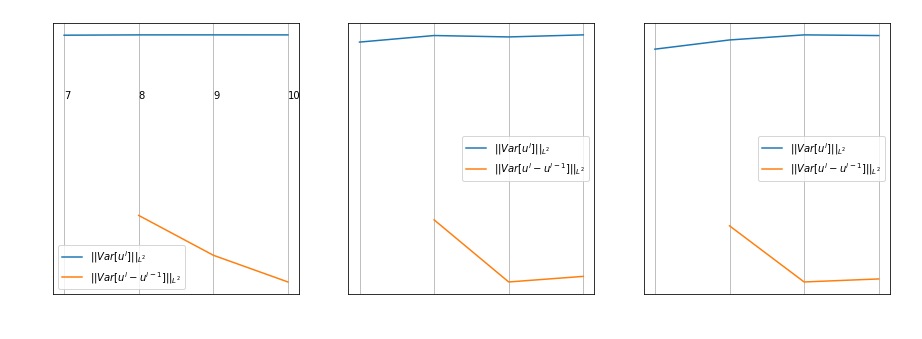

In [61]:
fig, axs = plt.subplots(1,3, figsize=(15,5))

Nxs = (2**np.array(ls))**2
for i in range(3):
    axs[i].loglog(Nxs, vars[:,i], label="$|| Var[u^l] ||_{L^2}$")
    axs[i].loglog(Nxs[1:], diff_vars[1:,i], label="$|| Var[u^l-u^{l-1}] ||_{L^2}$")
    axs[i].set_xlabel("# grid cells")
    axs[i].set_ylabel("variance")
    axs[i].legend(labelcolor="black")

    axs[i].set_xticks(Nxs)
    axs[i].xaxis.grid(True)

    for l_idx, l in enumerate(ls):
        axs[i].annotate(str(l), (Nxs[l_idx], 1e-5), color="black")

axs[0].set_title("eta")
axs[1].set_title("hu")
axs[2].set_title("hv")